In [0]:
!pip install tensorflow==2.1.0

In [0]:
!pip install tensorflow-quantum

In [0]:
import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


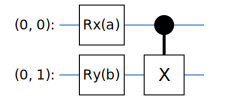

In [2]:
a, b = sympy.symbols('a b')

# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), 
    cirq.CNOT(control=q0, target=q1))

SVGCircuit(circuit)

In [3]:
# Calculate a state vector with a=0.5 and b=-0.5.
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

In [4]:
z0 = cirq.Z(q0)
qubit_map={q0: 0, q1: 1}
z0.expectation_from_wavefunction(output_state_vector, qubit_map).real

0.8775825500488281

In [5]:
z0x1 = 0.5 * z0 + cirq.X(q1)
z0x1.expectation_from_wavefunction(output_state_vector, qubit_map).real

-0.04063427448272705

In [6]:
# Rank 1 tensor containing 1 circuit.
circuit_tensor = tfq.convert_to_tensor([circuit])
print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [7]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
print(pauli_tensor.shape)
print(pauli_tensor.dtype)

(2,)
<dtype: 'string'>


In [8]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)
batch_vals.shape

(5, 2)

In [9]:
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state = cirq_simulator.simulate(circuit, resolver).final_state
    cirq_results.append([z0.expectation_from_wavefunction(final_state, {q0: 0, q1: 1}).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[-0.94593042]
 [-0.80017149]
 [-0.35972166]
 [ 0.50041819]
 [ 0.85563284]]


In [10]:
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.94593066],
       [-0.80017155],
       [-0.35972175],
       [ 0.5004181 ],
       [ 0.85563296]], dtype=float32)>

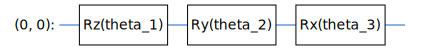

In [11]:
control_params = sympy.symbols('theta_1 theta_2 theta_3')

qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

In [12]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

controller(tf.constant([[0.0],[1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.02691381, -0.02700801, -0.5396717 ]], dtype=float32)

In [0]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(), dtype=tf.string, name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,), dtype=tf.dtypes.float32, name='commands_input')

dense = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense])

In [0]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

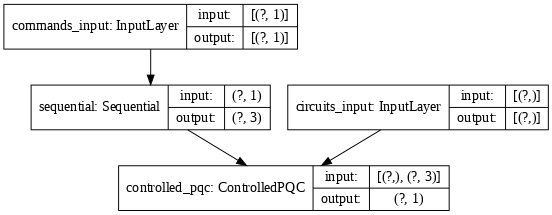

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [0]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [0]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)

datapoint_circuits = tfq.convert_to_tensor([noisy_preparation] * 2)

In [21]:
datapoint_circuits.shape

TensorShape([2])

In [22]:
model([datapoint_circuits, commands]).numpy()

array([[-0.0421485 ],
       [ 0.47713205]], dtype=float32)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

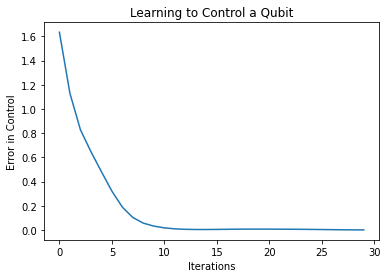

In [24]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [25]:
def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get expectation the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state
    
    expectation = z0.expectation_from_wavefunction(state, {qubit: 0}).real
    
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expectation}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [-0.5773039  -3.4047508  -0.85290694]
Which gives an actual expectation of: 0.9622211456298828

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [-0.13916625 -0.38096613  0.931672  ]
Which gives an actual expectation of: -0.9838959574699402



In [26]:
model([datapoint_circuits, commands])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.96222115],
       [-0.98389584]], dtype=float32)>